In [1]:
%pip install mesa
%pip install plotly==5.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [2]:
import mesa
import numpy as np

import seaborn as sns
import pandas as pd

from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
import random

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


In [3]:
def compute_gini(model):
    # Representa el nivel de desigualdad entre agentes (0-igualdad, 1-desigualdad)
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    if not agent_wealths:
        return 0.0

    agent_wealths.sort()
    N = len(agent_wealths)
    B = sum(xi * (N - i) for i, xi in enumerate(agent_wealths)) / (N*sum(agent_wealths))
    gini = 1 + (1 / N) - 2 * B
    return gini

In [4]:
class Trader(mesa.Agent):
      # Agente Trader
      def __init__(self, model, risk, trader_type):
        super().__init__(model)
        self.portfolio = {"stock": 0, "wealth": 1000}
        self.risk = risk
        self.wealth = self.portfolio["wealth"]
        self.demand = self.random.uniform(0, 1)
        self.trader_type = trader_type

      def step(self):
        self.demand += self.random.uniform(-0.1, 0.1)
        self.demand = np.clip(self.demand, 0, 1)

        if self.trader_type == "value":
            firms = [a for a in self.model.schedule.agents if isinstance(a, Firm)]
            if firms:
                firm = random.choice(firms)
                if firm.available_shares > 0 and firm.stock_price < firm.wealth / firm.available_shares:
                    self.buy_stock_from_firm(firm)
                else:
                    self.sell_stock_to_firm(firm)

        elif self.trader_type == "momentum":
            firms = [a for a in self.model.schedule.agents if isinstance(a, Firm)]
            if firms:
                firm_momentum = max(firms, key=lambda f: f.stock_price_history[-1] - f.stock_price_history[-2] if len(f.stock_price_history) >= 2 else 0)
                self.buy_stock_from_firm(firm_momentum)


      def buy_stock_from_firm(self, firm):

        if self.portfolio["wealth"] > 0 and firm.available_shares > 0:
            stock_price = firm.stock_price
            quantity = int(self.portfolio["wealth"] / stock_price)
            if quantity > firm.available_shares:
                quantity = firm.available_shares

            self.portfolio["stock"] += quantity
            self.portfolio["wealth"] -= quantity * stock_price
            firm.available_shares -= quantity
            firm.wealth += quantity * stock_price

      def sell_stock_to_firm(self, firm):

        if self.portfolio["stock"] > 0:
            stock_price = firm.stock_price
            if self.model.crisis_triggered:
                panic_factor = 0.8
                stock_price *= panic_factor

            self.portfolio["wealth"] += self.portfolio["stock"] * stock_price
            self.portfolio["stock"] = 0
            firm.available_shares += self.portfolio["stock"]
            firm.wealth -= self.portfolio["stock"] * stock_price

In [5]:
class Firm(mesa.Agent):
    # Agente Firm
    def __init__(self, model):
        super().__init__(model)
        wealth_range = (5000, 20000)
        stock_price_range = (5, 20)
        self.wealth = self.random.uniform(*wealth_range)
        self.stock_price = self.random.uniform(*stock_price_range)
        self.available_shares = 1000
        self.stock_price_history = []
        self.demand = self.random.uniform(0, 1)

    def step(self):
        price_change = self.random.uniform(-1, 1) * self.demand
        self.stock_price += price_change

        self.demand += self.random.uniform(-0.1, 0.1)
        self.demand = np.clip(self.demand, 0, 1)

        self.stock_price_history.append(self.stock_price)
        if self.available_shares > 0 and self.random.random() < 0.5:
            self.available_shares -= 1
            self.wealth += self.stock_price

In [6]:
class StockMarketModel(mesa.Model):
    # Modelo del mercado
    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.agents.shuffle_do("step")

        self.crisis_triggered = False
        self.crisis_threshold = 0.25
        self.steps_since_last_crisis = 0
        self.crisis_frequency = 600
        self.crisis_duration = 250
        self.crisis_duration_counter = 0
        risk = 0.5

        # Se crean los firms
        for i in range(N // 2):
            f = Firm(self)
            self.schedule.add(f)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(f, (x, y))

        # Se crean los traders
        for i in range(N // 2, N):
            trader_type = self.random.choice(["value", "momentum"])
            t = Trader(self, risk, trader_type)
            self.schedule.add(t)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(t, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Gini": compute_gini,
                "AvgStockPrice": lambda m: np.mean([a.stock_price for a in m.schedule.agents if isinstance(a, Firm)]),
                "AvgWealth": lambda m: np.mean([a.wealth for a in m.schedule.agents]),
                "AvgDemandTraders": lambda m: np.mean([a.demand for a in m.schedule.agents if isinstance(a, Trader)]),
                "AvgDemandFirms": lambda m: np.mean([a.demand for a in m.schedule.agents if isinstance(a, Firm)])
            },
            agent_reporters={"Wealth": "wealth", "Demand": "demand"})

    def step(self):
        self.datacollector.collect(self)
        self.agents.do("step")

        self.steps_since_last_crisis += 1
        avg_trader_demand = np.mean([a.demand for a in self.schedule.agents if isinstance(a, Trader)])
        avg_firm_demand = np.mean([a.demand for a in self.schedule.agents if isinstance(a, Firm)])

        if avg_trader_demand < self.crisis_threshold or avg_firm_demand < self.crisis_threshold:
            if not self.crisis_triggered:
                self.trigger_crisis()
                self.crisis_triggered = True
                self.steps_since_last_crisis = 0

        if self.steps_since_last_crisis >= self.crisis_frequency and not self.crisis_triggered:
            self.trigger_crisis()
            self.crisis_triggered = True
            self.steps_since_last_crisis = 0

        if self.crisis_triggered:
            self.crisis_duration_counter += 1
            if self.crisis_duration_counter >= self.crisis_duration:
                self.deactivate_crisis()
                self.crisis_triggered = False
                self.crisis_duration_counter = 0

    def calculate_max_wealth(self):
        self.max_firm_wealth = 0
        self.max_trader_wealth = 0

        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
                self.max_firm_wealth = max(self.max_firm_wealth, agent.wealth)
            elif isinstance(agent, Trader):
                self.max_trader_wealth = max(self.max_trader_wealth, agent.portfolio["wealth"])

    def trigger_crisis(self):
        print("Economic Crisis Triggered")
        self.calculate_max_wealth()
        # Firmas y traders más ricos pierden más
        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
              reduction_factor = 1 - (agent.wealth / self.max_firm_wealth) * 0.2
              agent.stock_price *= reduction_factor
              agent.wealth *= reduction_factor
            elif isinstance(agent, Trader):
              reduction_percentage = 1 - (agent.wealth / self.max_trader_wealth) * 0.2
              agent.portfolio["wealth"] *= reduction_percentage
              agent.risk *= 1.5

    def deactivate_crisis(self):
        print("Economic Crisis Deactivated")

        for agent in self.schedule.agents:
            if isinstance(agent, Firm):
                agent.stock_price *= 1.15
                agent.wealth *= 1.1
            elif isinstance(agent, Trader):
                agent.portfolio["wealth"] *= 1.1
                agent.risk *= 0.67

In [7]:
def plot_interactive_charts(model):
    # Charts using Plotly.
    df = model.datacollector.get_model_vars_dataframe()
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                        subplot_titles=("Gini Coefficient", "Average Stock Price", "Average Wealth"))

    fig.add_trace(go.Scatter(x=df.index, y=df["Gini"], name="Gini Coefficient"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df["AvgStockPrice"], name="Average Stock Price"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df["AvgWealth"], name="Average Wealth"), row=3, col=1)

    fig.update_layout(height=900, width=1200, title_text="Modelo Mercado Económico gráficos")

    agent_wealth = model.datacollector.get_agent_vars_dataframe()
    agent_wealth = agent_wealth.reset_index()
    fig_wealth_dist = px.histogram(agent_wealth, x="Wealth", animation_frame="Step",
                                   title="Distribución de Wealth por iteración")
    fig_wealth_dist.update_layout(height=600, width=1200)

    fig_wealth_dist.show()
    fig.show()

In [24]:
model = StockMarketModel(50, 10, 10)
for i in range(1000):
    model.step()

<ipython-input-6-96e898015dc2>:7: DeprecationWarning:

The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers



Economic Crisis Triggered
Economic Crisis Deactivated


In [25]:
plot_interactive_charts(model)

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



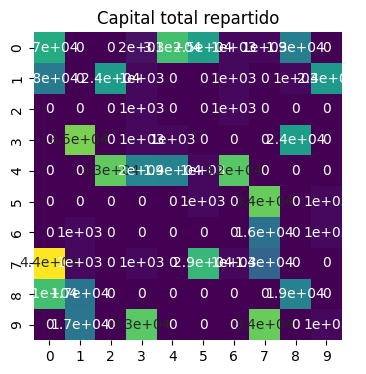

In [26]:
trader_cash = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, (x, y) = cell
    for agent in cell_content:
        #if isinstance(agent, Trader):
            trader_cash[x][y] += agent.wealth


g = sns.heatmap(trader_cash, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
plt.title("Capital total repartido");
plt.savefig("heatmap.png")
plt.show()

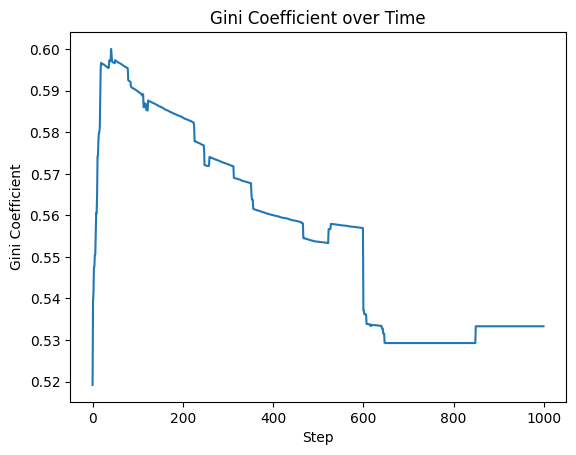

In [27]:
gini = model.datacollector.get_model_vars_dataframe()["Gini"]

g = sns.lineplot(data=gini)
plt.title("Gini Coefficient over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")
plt.show()

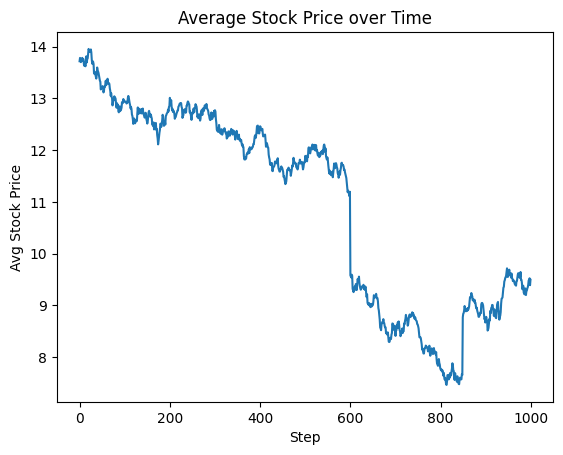

In [28]:
avg_stock_price = model.datacollector.get_model_vars_dataframe()["AvgStockPrice"]

sns.lineplot(data=avg_stock_price)
plt.title("Average Stock Price over Time")
plt.xlabel("Step")
plt.ylabel("Avg Stock Price")
plt.show()

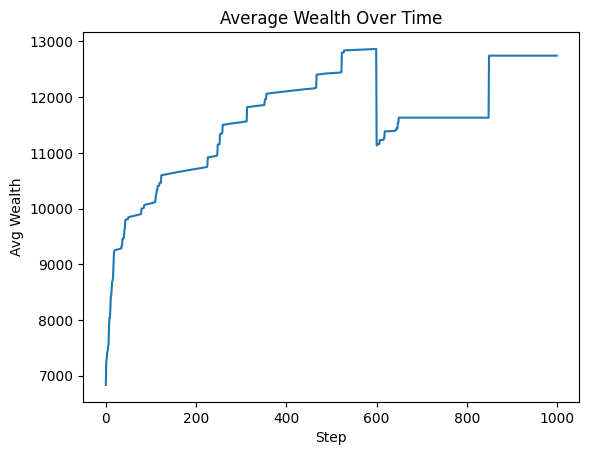

In [29]:
avg_wealth = model.datacollector.get_model_vars_dataframe()["AvgWealth"]

sns.lineplot(data=avg_wealth)
plt.title("Average Wealth Over Time")
plt.xlabel("Step")
plt.ylabel("Avg Wealth")
plt.show()

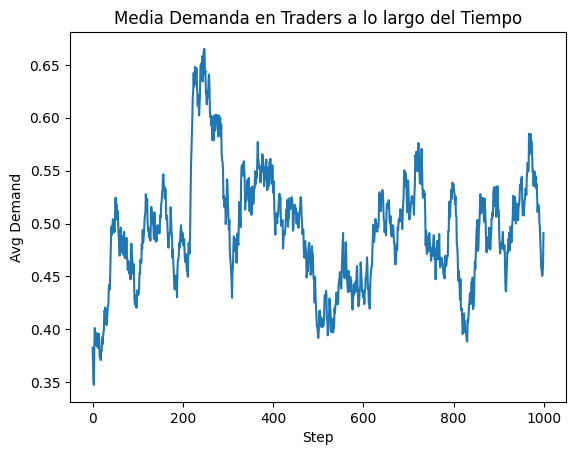

In [30]:
avg_demandT = model.datacollector.get_model_vars_dataframe()["AvgDemandTraders"]

sns.lineplot(data=avg_demandT)
plt.title("Media Demanda en Traders a lo largo del Tiempo")
plt.xlabel("Step")
plt.ylabel("Avg Demand")
plt.savefig("demandT.png")
plt.show()

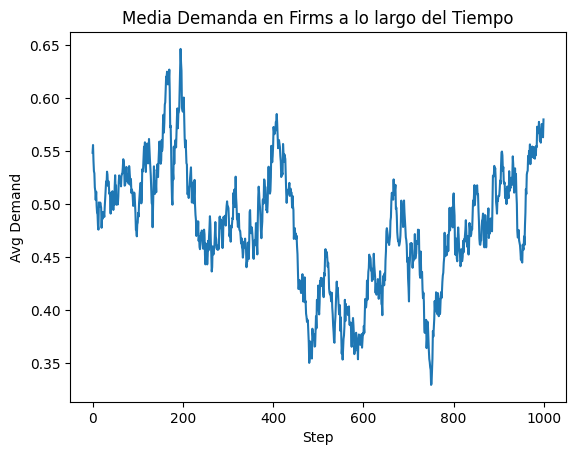

In [31]:
avg_demandF = model.datacollector.get_model_vars_dataframe()["AvgDemandFirms"]

sns.lineplot(data=avg_demandF)
plt.title("Media Demanda en Firms a lo largo del Tiempo")
plt.xlabel("Step")
plt.ylabel("Avg Demand")
plt.savefig("demandF.png")
plt.show()